# EM Algorithm (2023)

On souhaite appliquer l'algorithme EM sur une mixture unidimensionnelle de 2 Gaussiennes, avec pour moyennes, variances et proportions respectives:  $\mu_1 = 0$, $\mu_2 = 4$, $\sigma^2_1 = 1$, $\sigma^2_2 = \frac{1}{2}$ et $\pi_1 = \frac{1}{3}$

On note N la taille de la mixture et $X = (x_1, x_2, ..., x_N)$ un échantillon de la mixture.

Pour cela, nous allons d'abord implémenter un algorithme EM générique gaussien avec un nombre $K$ inconnu de distributions gaussiennes ($K \le N$) puis l'appliquer à notre cas particulier.

On note $N(x; \mu, \sigma^2)$ la distribution gaussienne et $\Theta^{(q)} = (\mu_1^{(q)}, ... ,\mu_K^{(q)}, (\sigma^2_1)^{(q)}, ...,  (\sigma^2_K)^{(q)}, \pi_1^{(q)}, ..., \pi_K^{(q)})$ les paramètres calculés à la $(q)$ ème itération, où $\forall (q), \sum_{k=1}^{K} \pi_k^{(q)} = 1$.

La mixture est donc sous la forme:
$$
\boxed{\sum_{j = 1}^{j = K} \pi_j^{(q)} * N(x_i, \mu_j^{(q)}, (\sigma^2_j)^{(q)})}
$$


## Initialisation de l'algorithme EM

Arbitrairement, on pose des valeurs initiales pour $\Theta^{(0)}$ tels que:
- $\forall k \in \{1, ..., K\}, \mu_k^{(0)}$ vaut un élément de $X$ choisi aléatoirement selon une loi uniforme ($\mu_k^{(0)} = x_i \ où \ i$ ~ $U(\{1, ..., N\})$),
- $\forall k \in \{1, ..., K\}, (\sigma^{2}_k)^{(0)} = 1$,
- $\forall k \in \{1, ..., K\}, \pi_k^{(0)} = \frac{1}{K}$.


Dans la suite, on considèrera: 
- $\forall i \in \{1, ..., N\}, \forall k \in \{1, ..., K\}, z_{i,k}$, la variable latente binaire associé à la composante $x_i$ et qui indique si $x_i$ provient de la distribution $k$.
- $\forall i \in \{1, ..., N\}, \forall k \in \{1, ..., K\}, t_{i,k} = \mathbb{P}(z_{i,k} = 1 | X_i = x_i)$, la probabilité conditionnelle que $z_{i,k} = 1$ sachant $x_i$.

On note l'indice ($q$), qui indique la $q^{ème}$ de l'itération.

Nous devons également définir un critère de convergence, nous allons itérer l'algorithme tant que :
$$
\boxed{\frac{\|\Theta^{(q)} - \Theta^{(q+1)}\|_2}{\|\Theta^{(q)}\|_2^2} \le \epsilon}
$$
et on se fixera $\epsilon = 10^{-6}$

In [28]:
##==============================================================================
# Imports
##==============================================================================
import numpy as np
import matplotlib.pyplot as plt
import random

In [29]:
##==============================================================================
# Class Gaussian
#
# Cette classe permet de créer une distribution gaussienne à partir de sa moyenne et de sa variance
##==============================================================================
class Gaussian():
    def __init__(self, mu, sigma2):
        self.mu = mu
        self.sigma2 = sigma2

    def __repr__(self):
        return f"Gaussian(µ={self.mu}, σ²={self.sigma2})"

    # Probability Density Function
    def pdf(self, x):
        return (1 / (self.sigma2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - self.mu) / self.sigma2) ** 2)

    def plot_pdf(self, x_min, x_max):
        x = np.linspace(x_min, x_max, 100)
        y = self.pdf(x)
        plt.plot(x, y, label=self.__repr__())
        plt.grid()
        plt.legend()

## E-step

On a:
$$
\forall i \in \{1, ..., N\}, \forall k \in \{1, ..., K\}, \forall (q), t_{i, k}^{(q)} = \frac{\pi_k^{(q)} * N(x_i, \mu_k^{(q)}, (\sigma^2_k)^{(q)})}{\sum_{j = 1}^{j = K} \pi_j^{(q)} * N(x_i, \mu_j^{(q)}, (\sigma^2_j)^{(q)})}
$$

*Justification: On utilise la formule de Bayes.*

On calcule ensuite l'expression $Q(\Theta, \Theta^{(q)}) = \mathbb{E}_{Z|X, \Theta^{(q)}}[log(P(X, Z; \Theta))]$, où $log(P(X, Z; \Theta))$ est la log-vraisemblance de la mixture.

Dans le cas de distributions gaussiens, on a: $Q(\Theta, \Theta^{(q)}) = \mathbb{E}_{Z|X, \Theta^{(q)}} [log(\prod_{i = 1}^{i = N} \sum_{k = 1}^{k = K} \pi_k^{(q)} * N(x_i, \mu_k^{(q)}, (\sigma^2_k)^{(q)}))] \\$
$= \mathbb{E}_{Z|X, \Theta^{(q)}} [log(\prod_{i = 1}^{i = N} \prod_{k = 1}^{k = K} (\pi_k^{(q)} * N(x_i, \mu_k^{(q)}, (\sigma^2_k)^{(q)}))^{\mathbf{1[z_{i,k} = 1]}})]$
$$= \sum_{i = 1}^{i = N} \sum_{k = 1}^{k = K} \mathbb{E}_{Z|X, \Theta^{(q)}} [\mathbb{1[z_{i,k} = 1]}] (log(\pi_k^{(q)}) + log(\frac{1}{\sqrt{2\pi}(\sigma^2_k)^{(q)}}) + \frac{(- (x_i - \mu_k^{(q)})^2)}{2((\sigma^2_k)^{(q)})^2})
$$
$$\boxed{= \sum_{i = 1}^{i = N} \sum_{k = 1}^{k = K} t_{i,k}^{(q)} (log(\pi_k^{(q)}) + log(\frac{1}{\sqrt{2\pi}(\sigma^2_k)^{(q)}}) + \frac{(- (x_i - \mu_k^{(q)})^2)}{2((\sigma^2_k)^{(q)})^2})}
$$

In [30]:
##==============================================================================
## Fonction E_step
##
## Paramètres :
##      mu : liste des moyennes à l'itération (q)  (taille K)
##      sigma : liste des variances à l'itération (q)  (taille K)
##      pi : liste des poids à l'itération (q)  (taille K)
##      mixture : liste des données  (taille N)
##
## Retour :
##      Q : valeur de l'expression Q à l'itération courante
##      tik_list : liste des tik à l'itération courante (taille K x N)
##==============================================================================
def E_step(mu:list, sigma:list, pi:list, mixture):
    gaussian_list = []
    tik_list = np.zeros((len(mu), len(mixture)))
    Q = 0
    for k in range(len(mu)):
        gaussian_list.append(Gaussian(mu[k], sigma[k]).pdf(mixture))
        tik_list[k] = pi[k] * gaussian_list[k]  # Numérateur de tik

    # Division par le dénominateur de tik
    tik_list /= np.sum(tik_list, axis=0)

    # Calcul de la fonction Q
    Q = np.sum(tik_list * np.log(np.array([pi[k] * gaussian_list[k] for k in range(len(mu))])))

    return [Q, tik_list]

## M-step

On cherche à maximiser $Q(\Theta, \Theta^{(q)})$ par rapport à $\Theta$.
On aura alors $\Theta^{(q+1)} = argmax_{\Theta} Q(\Theta, \Theta^{(q)})$.

Une méthode que l'on peut utiliser est l'annulation de la dérivée de $Q(\Theta, \Theta^{(q)})$ par rapport à $\Theta$, et la méthode du Lagrangien lorsque cela est nécessaire. On cherche ici à annuler les dérivées partielles de $Q(\Theta, \Theta^{(q)})$ par rapport à $\mu_k$ et $\sigma_k$, et on utilise le Lagrangien pour $\pi_k$.

Pour une distribution gaussienne, on peut démontrer que:

$\forall k \in \{1, ..., K\}, \frac{\partial Q(\Theta, \Theta^{(q)})}{\partial \mu_k} = \sum_{i = 1}^{i = N} t_{i,k}^{(q)} (x_i - \mu_k^{(q)}) = 0$
$$
\boxed{\forall k \in \{1, ..., K\}, \mu_k^{(q+1)} = \frac{\sum_{i = 1}^{i = N} t_{i,k}^{(q)} x_i}{\sum_{i = 1}^{i = N} t_{i,k}^{(q)}}}
$$
$\forall k \in \{1, ..., K\}, \frac{\partial Q(\Theta, \Theta^{(q)})}{\partial \sigma^2_k} = \sum_{i = 1}^{i = N} t_{i,k}^{(q)} (\frac{1}{\sigma_k^{(q)}} - \frac{(x_i - \mu_k^{(q)})^2}{((\sigma^2_k)^{(q)})^2}) = 0$
$$
\boxed{\forall k \in \{1, ..., K\}, (\sigma^2_k)^{(q+1)} = \frac{\sum_{i = 1}^{i = N} t_{i,k}^{(q)} (x_i - \mu_k^{(q+1)})^2}{\sum_{i = 1}^{i = N} t_{i,k}^{(q)}}}
$$
$\forall k \in \{1, ..., K\}, \frac{\partial Q(\Theta, \Theta^{(q)})}{\partial \pi_k} = \sum_{i = 1}^{i = N} t_{i,k}^{(q)} \frac{1}{\pi_k} - N = 0$
$$
\boxed{\forall k \in \{1, ..., K\}, \pi_k^{(q+1)} = \frac{\sum_{i = 1}^{i = N} t_{i,k}^{(q)}}{N}}
$$

On obtient alors les formules de mise à jour des paramètres de l'algorithme EM.

In [31]:
##==============================================================================
## Fonction M_step
##
## Paramètres :
##      tik_list : liste des tik à l'itération courante (taille K x N)
##      mixture : liste des données  (taille N)
##
## Retour :
##      mu : liste des moyennes à l'itération (q+1)  (taille K)
##      sigma : liste des variances à l'itération (q+1)  (taille K)
##      pi : liste des poids à l'itération (q+1)  (taille K)
##==============================================================================
def M_step(tik_list, mixture):
    n = len(mixture)
    mu = []
    sigma = []
    pi = []

    for k in range(np.shape(tik_list)[0]):
        mu.append(np.sum(tik_list[k] * mixture) / np.sum(tik_list[k]))
        sigma.append(np.sqrt(np.sum(tik_list[k] * (mixture - mu[k]) ** 2) / np.sum(tik_list[k])))
        pi.append(np.sum(tik_list[k]) / n)
    
    return [mu, sigma, pi]



## Exemple d'implémentation

### Exercice 1 TD Mixture de Gaussiennes

Nous allons appliquer l'algorithmes EM à une mixture de 2 gaussiennes, avec pour moyennes, variances et proportions respectives:  $\mu_1 = 0$, $\mu_2 = 4$, $\sigma^2_1 = 1$, $\sigma^2_2 = \frac{1}{2}$ et $\pi_1 = \frac{1}{3}$.

Pour chaque paramètre, nous allons travailler sur des listes pour conserver les valeurs de chaque itération. Ainsi, il sera possible de visualiser l'évolution des paramètres au cours des itérations par exemple. Pour réduire la consommation mémoire, on pourrait ne conserver que les valeurs de $\Theta^{(q)}$ et $\Theta^{(q+1)}$.

In [32]:
##==============================================================================
## Génération des données (mélange de 2 gaussiennes)
##==============================================================================

n = 1000
mu1 = 0
mu2 = 4
sigma1 = 1
sigma2 = 1/2
pi1 = 0.3
Z = np.zeros(n)
mixture = np.zeros(n)
for k in range(0, n):
    tmp = np.random.choice([1, 2], p=[pi1, 1 - pi1])
    Z[k] = tmp
    if tmp == 1:
        mixture[k] = np.random.normal(mu1, sigma1)
    else:
        mixture[k] = np.random.normal(mu2, sigma2)

##==============================================================================
## INITIALISATION
##==============================================================================
mu1_list = np.array([mixture[random.randint(0, n - 1)]])
mu2_list = np.array([mixture[random.randint(0, n - 1)]])
sigma1_list = np.array([1])
sigma2_list = np.array([1])
pi1_list = np.array([0.4])
ti1_list = np.array([0] * n)
Q = np.array([])

criteria = 10**(-6)


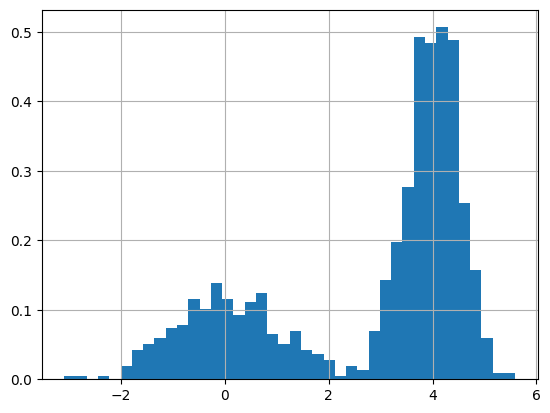

In [33]:
##==============================================================================
## Affichage de la distribution des données
##==============================================================================
plt.grid()
plt.hist(mixture, bins=40, density=True)
plt.show()

#### Algorithme EM

In [34]:
##==============================================================================
## Algorithme EM
##
## Cette fonction permet d'effectuer l'algorithme EM sur un mélange de K gaussiennes, à partir d'une liste de données.
## C'est un alhorithme itératif qui s'arrête lorsque que le critère de convergence défini plus haut est atteint.
##
## Paramètres :
##      mu1_list : liste des moyennes de la 1ere distribution, pour toutes les itérations
##      mu2_list : liste des moyennes de la 2eme distribution, pour toutes les itérations
##      sigma1_list : liste des variances de la 1ere distribution, pour toutes les itérations
##      sigma2_list : liste des variances de la 2eme distribution, pour toutes les itérations
##      pi1_list : liste des poids de la 1ere distribution, pour toutes les itérations
##      Q : liste des valeurs de l'expression Q, pour toutes les itérations
##      mixture : liste des données
##      conservation_value : booléen qui permet de choisir si on veut retourner les valeurs finales de la liste ou la liste complète
##
## Remarque:
##      Ce programme peut calculer l'algorithme EM pour un mélange de K gaussiennes. Il suffit simplement de modifier les arguments.
##==============================================================================
def EM(mu1_list, mu2_list, sigma1_list, sigma2_list, pi1_list, Q, mixture, conservation_value):
    
    E = E_step([mu1_list[-1], mu2_list[-1]], [sigma1_list[-1], sigma2_list[-1]], [pi1_list[-1], 1 - pi1_list[-1]], mixture)
    Q = np.append(Q, E[0])
    ti1_list = E[1][0]
    tik_list = E[1]
    

    try :
        if (len(Q) == 1 or (np.linalg.norm(np.array([mu1_list[-1], mu2_list[-1], sigma1_list[-1], sigma2_list[-1], pi1_list[-1]]) - np.array([mu1_list[-2], mu2_list[-2], sigma1_list[-2], sigma2_list[-2], pi1_list[-2]])) ** 2 / np.linalg.norm(np.array([mu1_list[-2], mu2_list[-2], sigma1_list[-2], sigma2_list[-2], pi1_list[-2]])) ** 2) > criteria):
            M = M_step(tik_list, mixture)
            mu1_list = np.append(mu1_list, M[0][0])
            mu2_list = np.append(mu2_list, M[0][1])
            sigma1_list = np.append(sigma1_list, M[1][0])
            sigma2_list = np.append(sigma2_list, M[1][1])
            pi1_list = np.append(pi1_list, M[2][0])
            return EM(mu1_list, mu2_list, sigma1_list, sigma2_list, pi1_list, Q, mixture, conservation_value)
        else:
            if (conservation_value):
                return mu1_list, mu2_list, sigma1_list, sigma2_list, pi1_list
            else:
                return mu1_list[-1], mu2_list[-1], sigma1_list[-1], sigma2_list[-1], pi1_list[-1]
    
    except:
        return "L'algorithme n'a pas convergé ou une erreur est survenue."
        

In [35]:
em = EM(mu1_list, mu2_list, sigma1_list, sigma2_list, pi1_list, Q, mixture, False)
print("Il y a convergence: mu1 = {}, mu2 = {}, sigma1 = {}, sigma2 = {}, pi1 = {}".format(round(em[0], 2), round(em[1], 2), round(em[2], 2), round(em[3], 2), round(em[4], 2)))

Il y a convergence: mu1 = 0.06, mu2 = 4.01, sigma1 = 1.04, sigma2 = 0.51, pi1 = 0.32


### Bonus

#### Affichage de l'évolution des paramètres

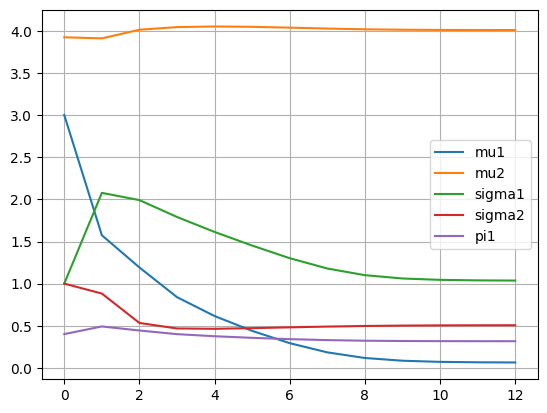

In [36]:
plt.grid()
em2 = EM(mu1_list, mu2_list, sigma1_list, sigma2_list, pi1_list, Q, mixture, True)
plt.plot(em2[0])
plt.plot(em2[1])
plt.plot(em2[2])
plt.plot(em2[3])
plt.plot(em2[4])
plt.legend(["mu1", "mu2", "sigma1", "sigma2", "pi1"])
plt.show()